Replication McKinnon (2016)
---------------------------

In [1]:
# Add Project Root to PYTHONPATH
import sys; sys.path.append('../..')

from heatwave import GHCN, GHCNElement, Country

import netCDF4

import pandas as pd
import numpy as np

from sklearn.cluster import AgglomerativeClustering, KMeans

from matplotlib import pyplot as plt, gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import date
import calendar
import os

### Data Cleaning & Selection

In [2]:
## Summer temperature observations are daily maxima from the
## Global Historical Climatology Network-Daily database

# Create GHCN Object to load weather station data:
# Particular Variable from particular Country in particular TimeSpan
ghcn = GHCN(GHCNElement.TMAX, Country.US)

# Load DataFrame from GHCN Data
df = ghcn.load()

# Format DataTime and Set as Index
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.set_index("DATE")

df[df == -9999] = np.nan  # Handle Not a Numbers (NaN's)
df /= 10  # Bring data from tenths of degrees C to whole degrees C

In [3]:
# Filter Stations outside of Mainland USA
ghcn_lat, ghcn_lon = ghcn.inventory["LAT"], ghcn.inventory["LON"]

mainland = ((ghcn_lat > 24) & (ghcn_lat < 50) & 
            (ghcn_lon > -130) & (ghcn_lon < -65))

df = df[mainland.index[mainland]]

In [4]:
## Filter Outliers, i.e. stations that have a temperature outside the [-50C, 70C] range

outliers = np.logical_and(df.min() > -50, df.max() < 70)
df = df[outliers.index[outliers]]

In [5]:
## Records from individual weather stations are included only if they have at least
## 80% coverage during June, July and August for at least 80% of the years considered in the analysis

jja = df[(df.index.month >= 6) & (df.index.month <= 8)]
jja_coverage = (jja.notnull().groupby(jja.index.year).mean() >= 0.8).mean() >= 0.8
df = df[jja_coverage.index[jja_coverage]]

In [6]:
## The analysis is confined to the 60 warmest days of summer based on the average 
## climatology across US weather stations (24 June-22 August on a non-leap year,
## and 23 June-21 August on a leap year)

def extract_summer(df):
    dfs = []
    for year in range(ghcn.span[0], ghcn.span[1]+1):
        if calendar.isleap(year):
            dfs.append(df.loc[f"23-06-{year}":f"21-08-{year}"])
        else:
            dfs.append(df.loc[f"24-06-{year}":f"22-08-{year}"])    
    return pd.concat(dfs)

summer = extract_summer(df)

### Clustering

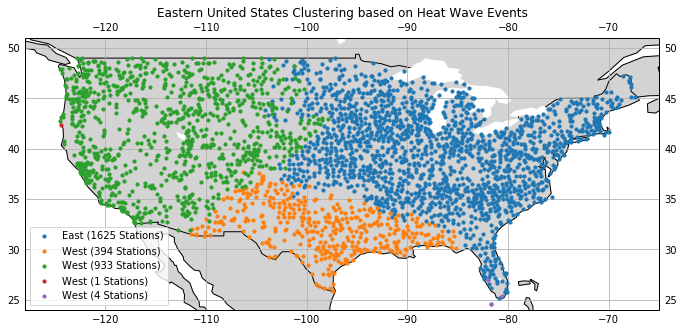

In [9]:
## The region of study is defined by grouping stations together using
## Hierarchical Agglomerative Clustering that minimizes the 
## average intra-cluster Jaccard distance between stations

## The comparison variable is an indicator function of whether or not a station has a
## temperature above the 95th percentile of its peak summer climatology
T95_bool_summer = summer > summer.quantile(0.95)

# Number if Clusters (2 for East/West)
N = 5

# Cluster Weather Station based on T95 (and T95 only)
# cluster = KMeans(N)
# cluster = AgglomerativeClustering(N)
cluster = AgglomerativeClustering(N, affinity="jaccard", linkage="average")
cluster.fit(T95_bool_summer.T)

# Get Latitude, Longitude and Label per Weather Station
lat = ghcn.inventory.loc[df.columns]["LAT"]
lon = ghcn.inventory.loc[df.columns]["LON"]

# Infer East Cluster based on cluster Longitude
cluster_lon = [np.mean(lon[cluster.labels_ == i]) for i in range(N) if np.sum(cluster.labels_ == i) > 100]
east_index = cluster_lon.index(max(cluster_lon))

# Create Big Figure
plt.rcParams['figure.figsize'] = [15, 5]

# create Projection and Map Elements
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES, color="white")
ax.add_feature(cfeature.LAND, color="lightgray")

# Define Map Extends
ax.set_xlim(-128, -65)
ax.set_ylim(24, 51)
ax.gridlines(
    xlocs=range(-180,181, 10),
    ylocs=range(-80,81, 5),
    draw_labels=True)

plt.title("Eastern United States Clustering based on Heat Wave Events\n")

# Plot Cluster Data
for index in range(N):
    label = "East" if index == east_index else "West"
    plt.scatter(lon[cluster.labels_==index],
                lat[cluster.labels_==index],
                transform=projection,
                s=10, zorder=10,
                label=f"{label} ({np.sum(cluster.labels_ == index)} Stations)")

plt.legend()
plt.show()

### East US T95

In [10]:
## To obtain a single quantity representative of both the magnitude and spatial extent of
## high temperatures for each summer day, we calculate the spatial 95th percentile of
## temperature anomalies across the eastern US cluster, referred to as T95 (Data set 1)

east_summer = summer[summer.columns[cluster.labels_ == east_index]]
east_summer_anomaly = east_summer - east_summer.mean()

T95 = east_summer_anomaly.quantile(0.95, 1)

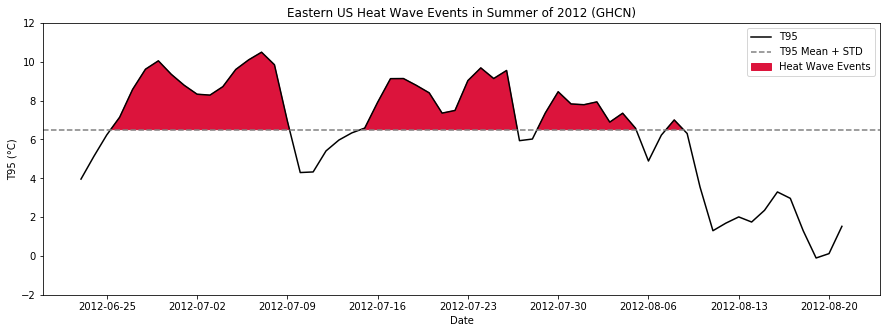

In [21]:
def plot_T95(T95, year, title=""):
    T95_std = T95.mean() + T95.std()

    # Create Big Figure
    plt.rcParams['figure.figsize'] = [15, 5]

    # Plot T95
    plt.title(f"Eastern US Heat Wave Events in Summer of {year} ({title})")
    plt.plot(T95[year], c="black", label="T95")
    plt.axhline(T95_std, c="gray", linestyle="--", label="T95 Mean + STD")
    plt.fill_between(T95[year].index, T95_std, T95[year], where=T95[year] > T95_std,
                     interpolate=True, color="crimson", label="Heat Wave Events")

    plt.ylabel("T95 (°C)")
    plt.xlabel("Date")
    plt.ylim(-2, 12)
    plt.legend()
    plt.show()
    
plot_T95(T95, "2012", "GHCN")

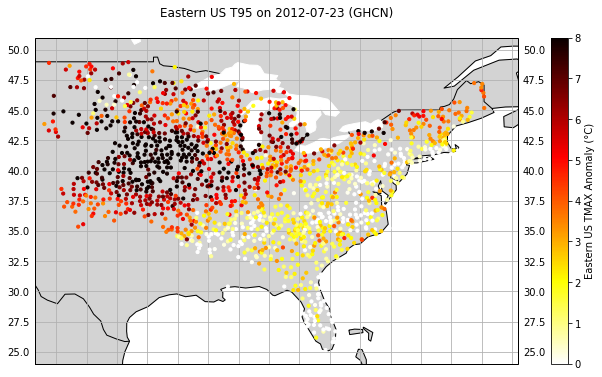

In [12]:
def plot_anomaly(anomaly, date="2012-07-23"):
    lat = ghcn.inventory.loc[anomaly.columns]["LAT"]
    lon = ghcn.inventory.loc[anomaly.columns]["LON"]

    # Create Big Figure
    plt.rcParams['figure.figsize'] = [12, 6]

    # create Projection and Map Elements
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAKES, color="white")
    ax.add_feature(cfeature.LAND, color="lightgray")

    # Define Map Extends
    ax.set_xlim(-105, -65)
    ax.set_ylim(24, 51)
    ax.gridlines(
        xlocs=np.linspace(0, 360, 144),
        ylocs=np.linspace(-90, 90, 73),
        draw_labels=True)

    plt.scatter(lon, lat, c=anomaly.loc[date], cmap="hot_r",
                vmin=0, vmax=8, transform=projection, s=10, zorder=10)

    plt.title(f"Eastern US T95 on {date} (GHCN)\n")
    plt.colorbar().ax.set_ylabel("Eastern US TMAX Anomaly (°C)")
    plt.show()
    
plot_anomaly(east_summer_anomaly)

Diverging from McKinnon
-----------------------

### ERA Interim 

In [13]:
## Load ERA T2M Dataset
t2m_dataset = netCDF4.Dataset(os.path.abspath('../../data/ERA/t2m_1979-2017_1_12_daily_2.5deg.nc'))
t2m = t2m_dataset['t2m'][:] - 273.15
t2m_lat = t2m_dataset['latitude'][:]
t2m_lon = t2m_dataset['longitude'][:]

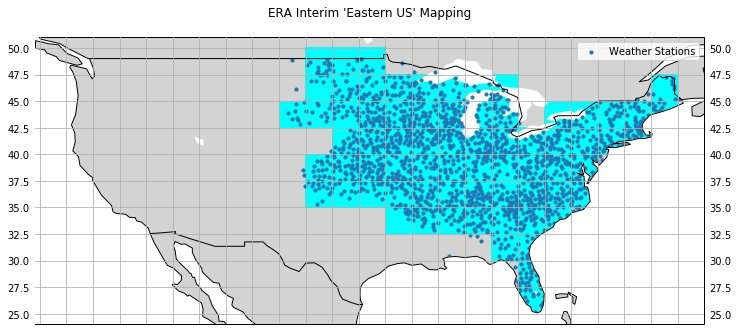

In [14]:
# ERA Interim Data Grid Size
t2m_lat_step = (t2m_lat[-1] - t2m_lat[0]) / (len(t2m_lat) - 1)
t2m_lon_step = (t2m_lon[-1] - t2m_lon[0]) / (len(t2m_lon) - 1)

# Latitudes and Longitudes of Clustered Eastern US
lat = ghcn.inventory.loc[east_summer_anomaly.columns]["LAT"]
lon = ghcn.inventory.loc[east_summer_anomaly.columns]["LON"]

# Latitudes and Longitudes of Clustered Eastern US, as indexes of ERA Interim Data Grid
lat_idx = ((lat - t2m_lat[0]) / t2m_lat_step).astype(np.int)
lon_idx = ((lon % 360) / t2m_lon_step).astype(np.int)

## Create Eastern US Mask ##
# ERA Interim Grid Cell is included
# at least MASK_STATION_THRESHOLD stations lie in Grid Cell
MASK_STATION_THRESHOLD = 5

# Create Mask
t2m_east_mask = np.zeros((len(t2m_lat), len(t2m_lon)), np.int)
for lat_i, lon_i in zip(lat_idx, lon_idx):
    t2m_east_mask[lat_i, lon_i] += 1
t2m_east_mask = t2m_east_mask >= MASK_STATION_THRESHOLD

# Create Big Figure
plt.rcParams['figure.figsize'] = [12, 6]

# create Projection and Map Elements
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.add_feature(cfeature.COASTLINE, zorder=30)
ax.add_feature(cfeature.BORDERS, zorder=30)
ax.add_feature(cfeature.LAKES, color="white")
ax.add_feature(cfeature.OCEAN, color="white", zorder=20)
ax.add_feature(cfeature.LAND, color="lightgray")

# Define Map Extends
ax.set_xlim(-128, -65)
ax.set_ylim(24, 51)

ax.gridlines(xlocs=np.arange(0, 360, 2.5),
             ylocs=np.arange(-90, 90, 2.5),
             draw_labels=True, zorder=40)

# Scatter Weather Station Locations and draw ERA Interim Eastern US Mask
plt.scatter(lon, lat, transform=projection, s=10, zorder=10, label="Weather Stations")

t2m_east_mask_plt = t2m_east_mask.astype(np.float)
t2m_east_mask_plt[t2m_east_mask_plt == 0] = np.nan

plt.pcolormesh(t2m_lon, t2m_lat, t2m_east_mask_plt, transform=projection, cmap="cool", label="ERA Interim Mask")

plt.title(f"ERA Interim 'Eastern US' Mapping\n")
legend = plt.legend().set_zorder(50)
plt.show()

In [15]:
east_summer_era = extract_summer(pd.DataFrame(t2m[:, t2m_east_mask], df.index))
east_summer_era_anomaly = east_summer_era - east_summer_era.mean()
T95_era = east_summer_era_anomaly.quantile(0.95, 1)

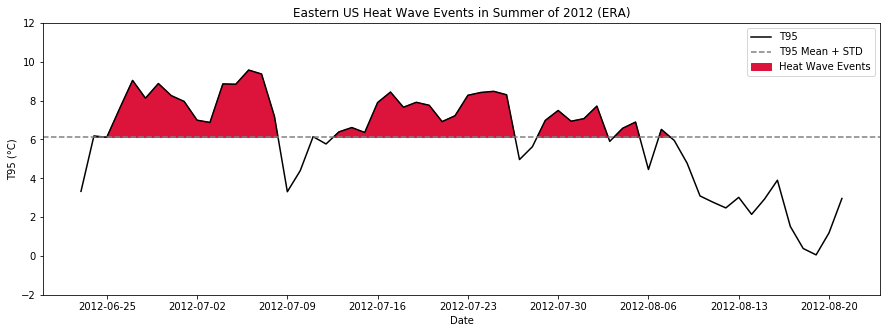

In [16]:
plot_T95(T95_era, "2012", "ERA")

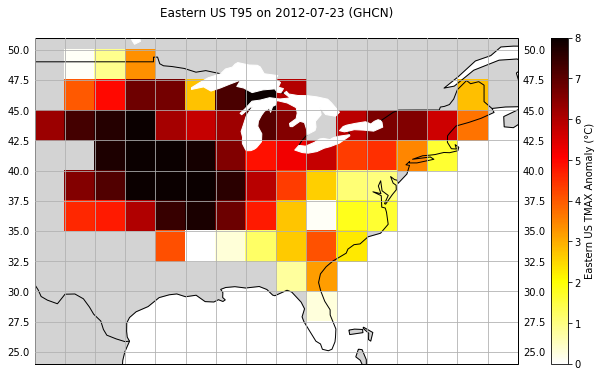

In [17]:
def plot_anomaly_t2m(anomaly, date="2012-07-23"):
    date_index = np.where(east_summer_era.index == date)[0][0]
    
    # Create Big Figure
    plt.rcParams['figure.figsize'] = [12, 6]

    # create Projection and Map Elements
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAKES, color="white")
    ax.add_feature(cfeature.LAND, color="lightgray")

    # Define Map Extends
    ax.set_xlim(-105, -65)
    ax.set_ylim(24, 51)
    ax.gridlines(xlocs=np.arange(0, 360, 2.5),
                 ylocs=np.arange(-90, 90, 2.5),
                 draw_labels=True, zorder=40)

    plt.pcolormesh(t2m_lon, t2m_lat, anomaly[date_index], vmin=0, vmax=8, cmap="hot_r", transform=projection)

    plt.title(f"Eastern US T95 on {date} (GHCN)\n")
    plt.colorbar().ax.set_ylabel("Eastern US TMAX Anomaly (°C)")
    plt.show()

east_summer_t2m = t2m[(east_summer_era_anomaly.index - df.index[0]).days]
east_summer_t2m[:, t2m_east_mask] -= east_summer_t2m[:, t2m_east_mask].mean(0)
east_summer_t2m[:, ~t2m_east_mask] = np.nan

plot_anomaly_t2m(east_summer_t2m)

Comparing GHCN & ERA
--------------------

In [18]:
McK = pd.read_csv(os.path.abspath('../../data/misc/PEP-T95TimeSeries.txt'))

GHCN<->ERA Mean Squared Error: 1.1340078648535243


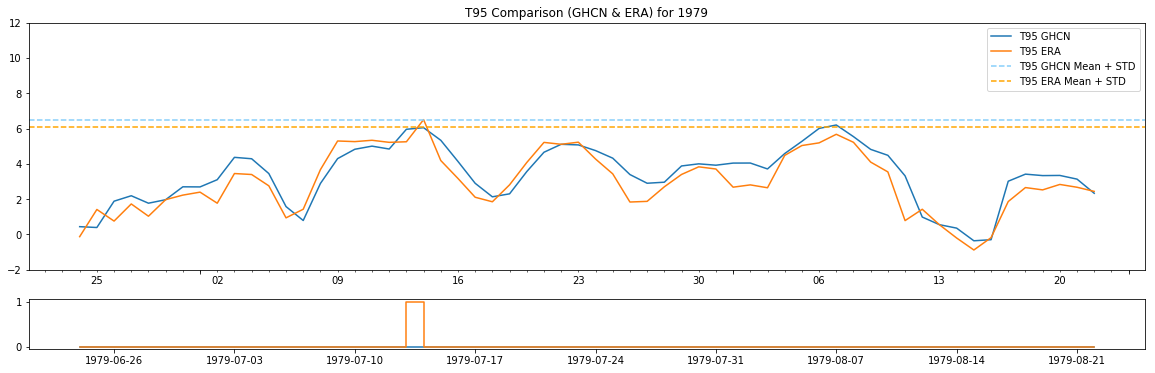

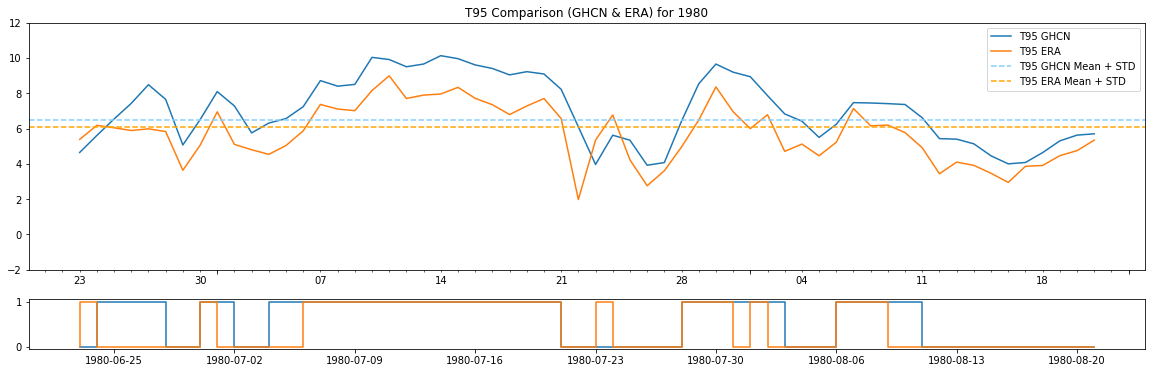

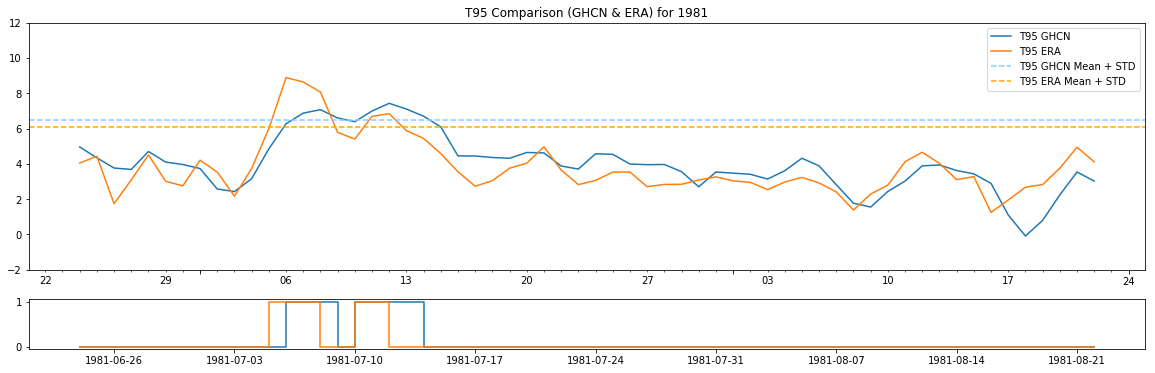

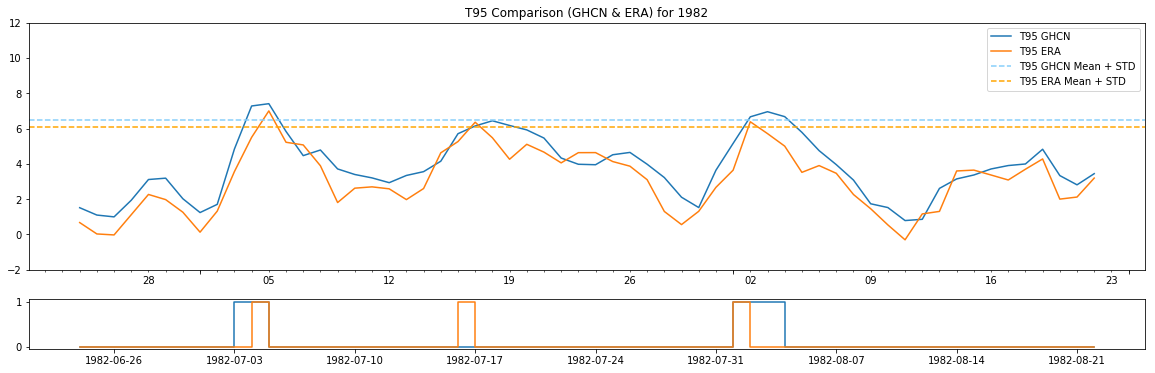

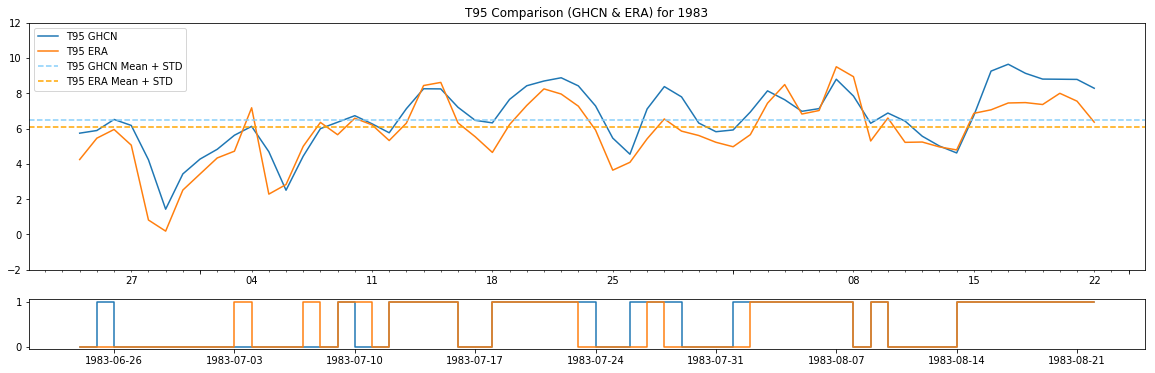

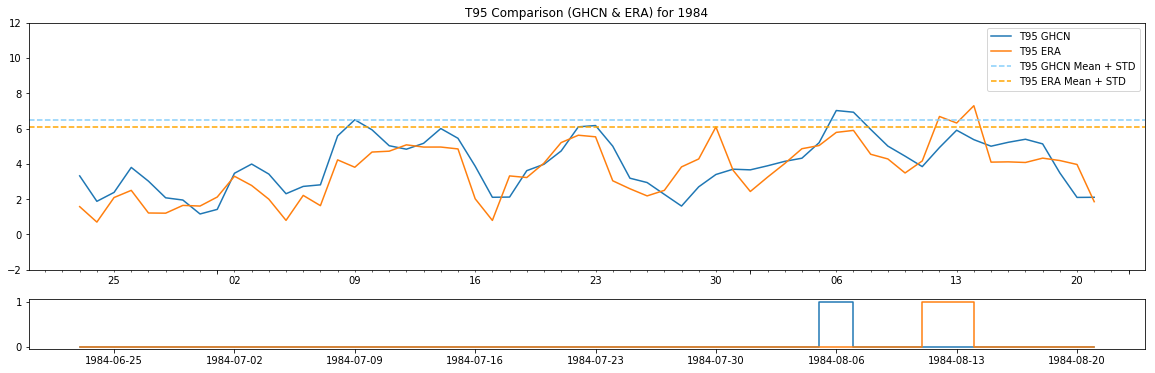

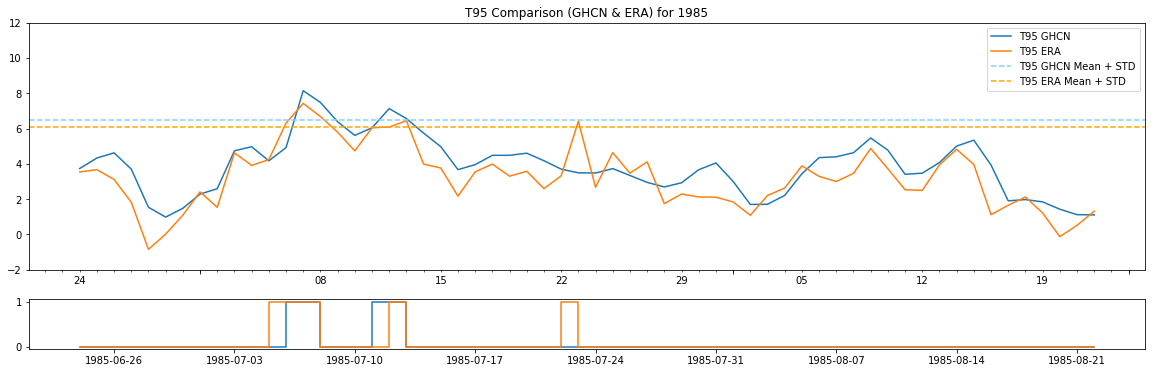

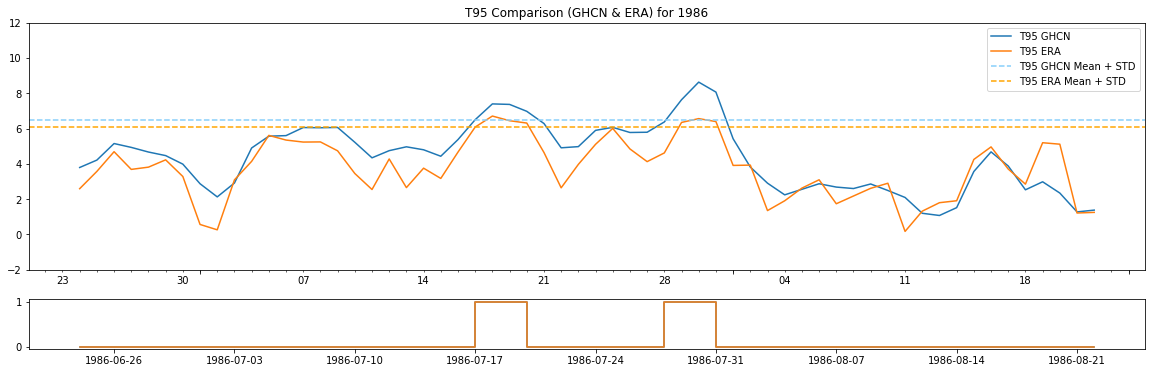

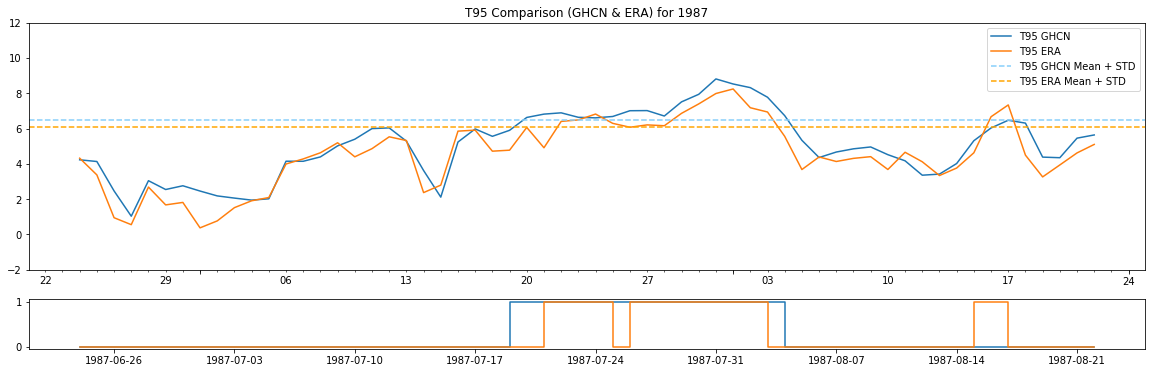

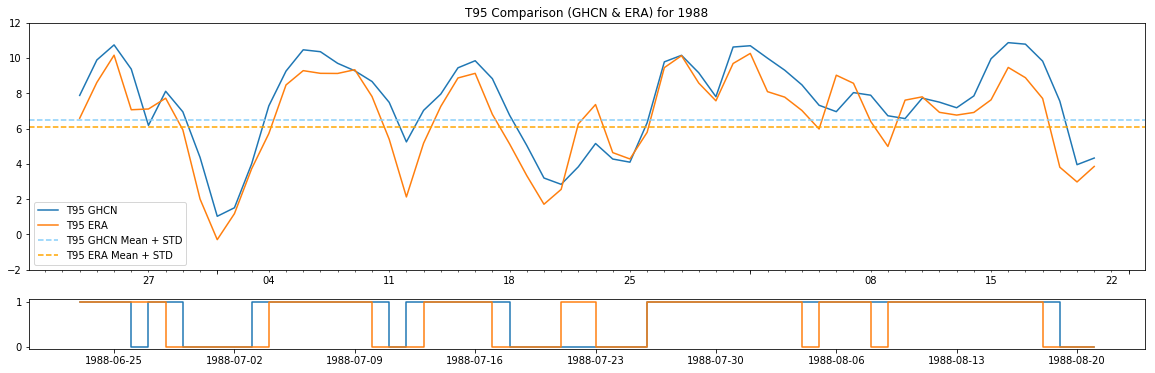

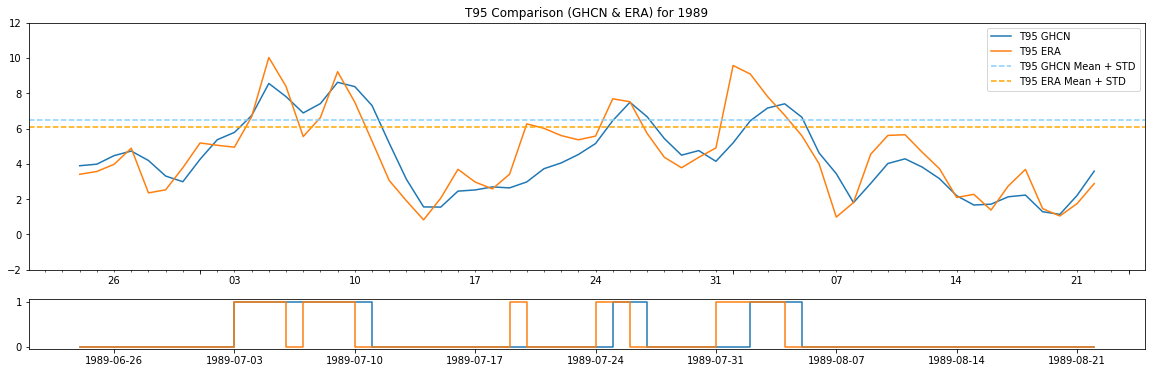

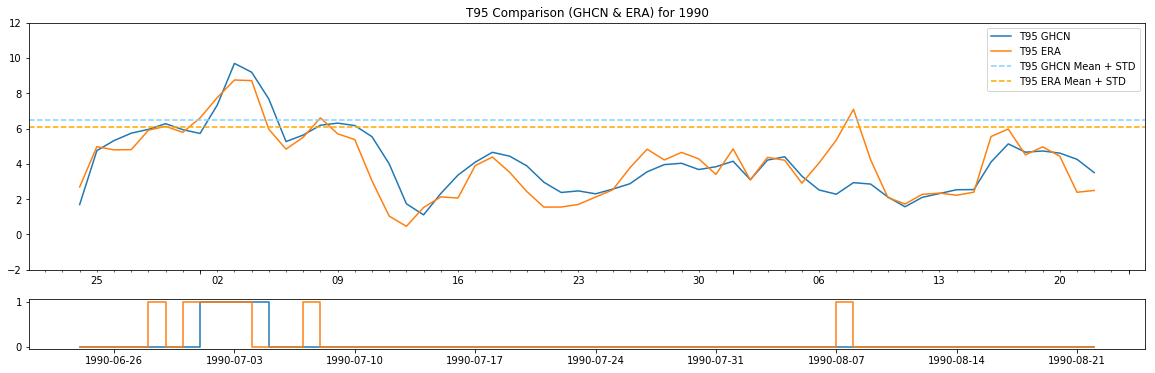

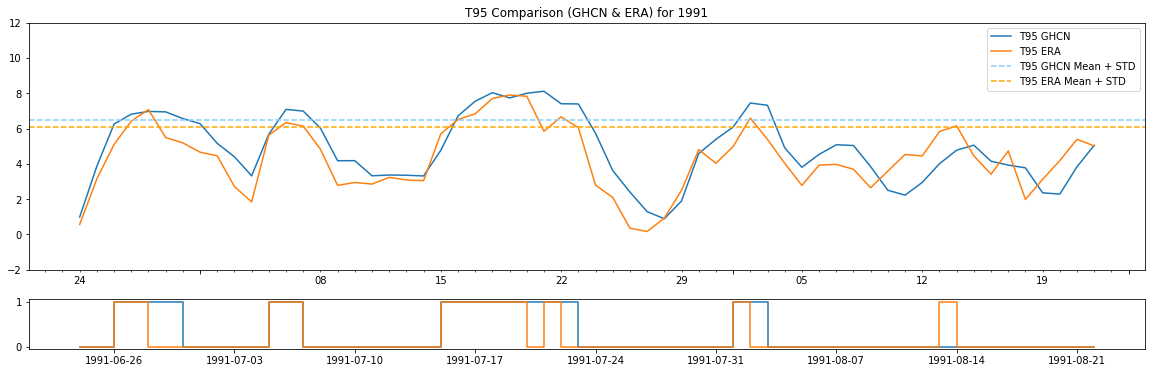

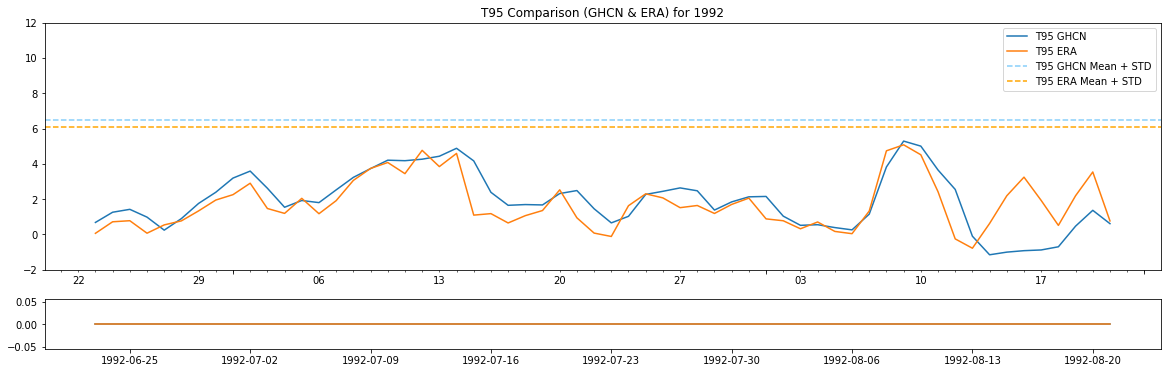

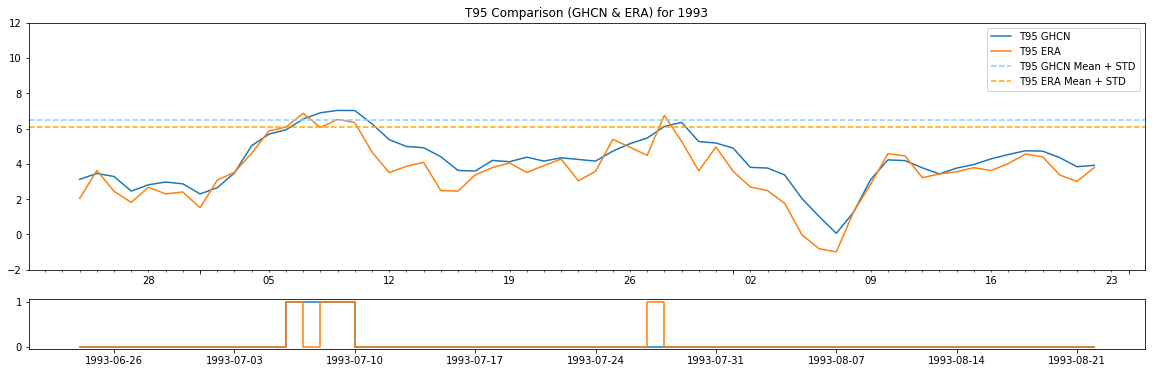

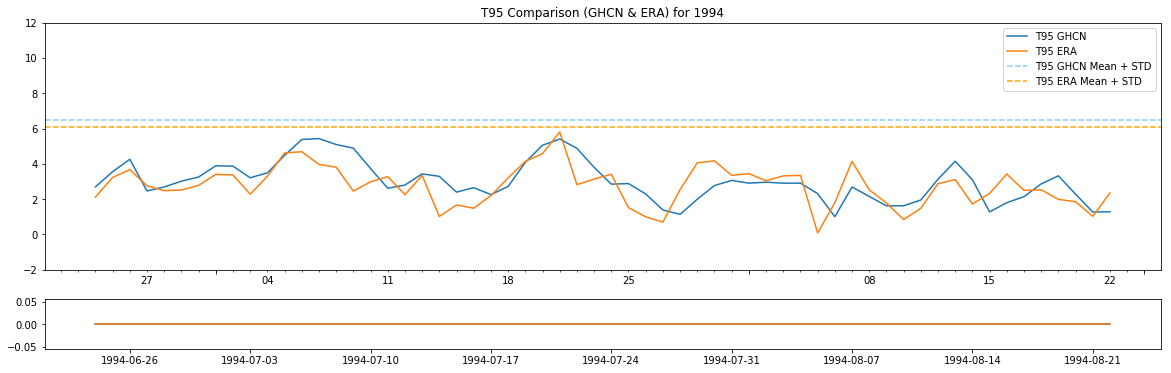

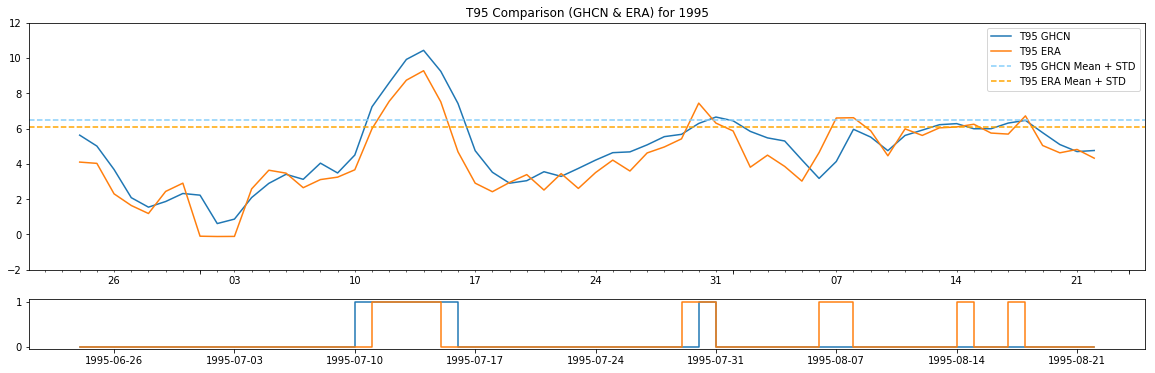

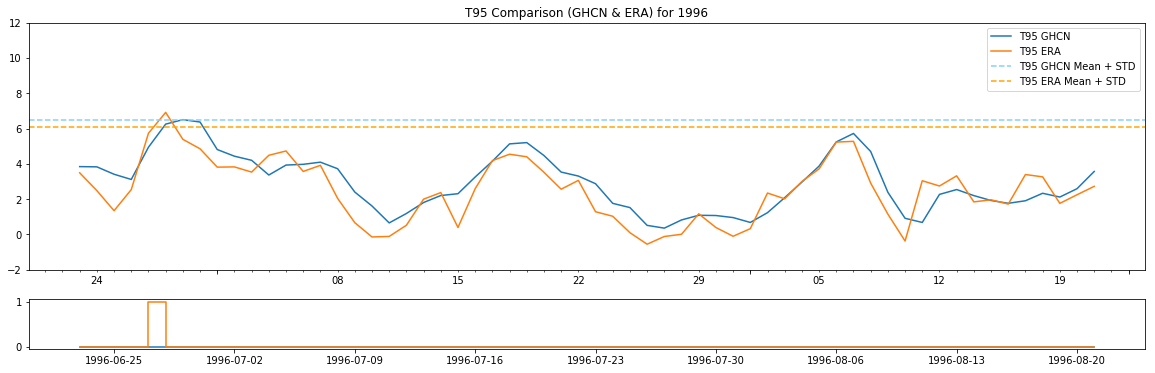

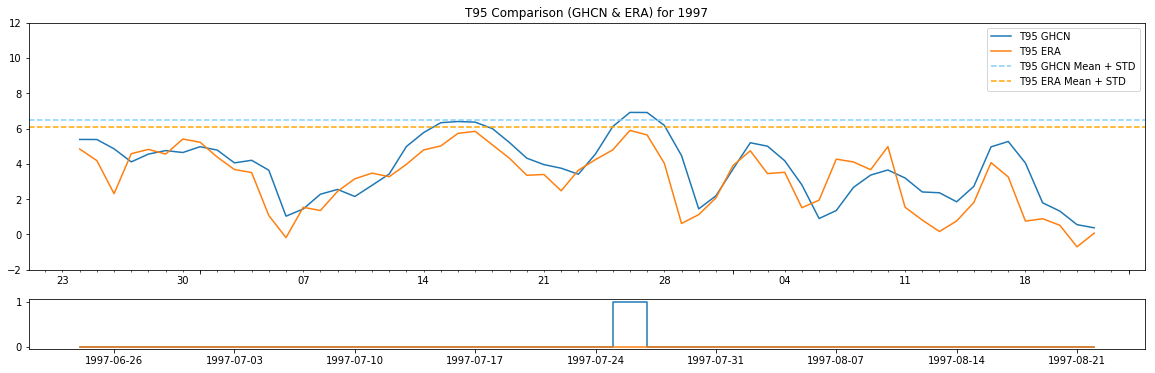

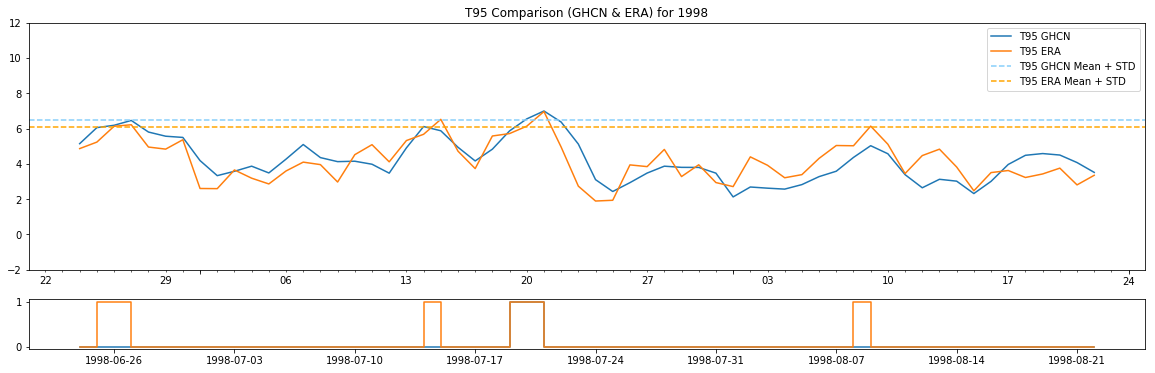

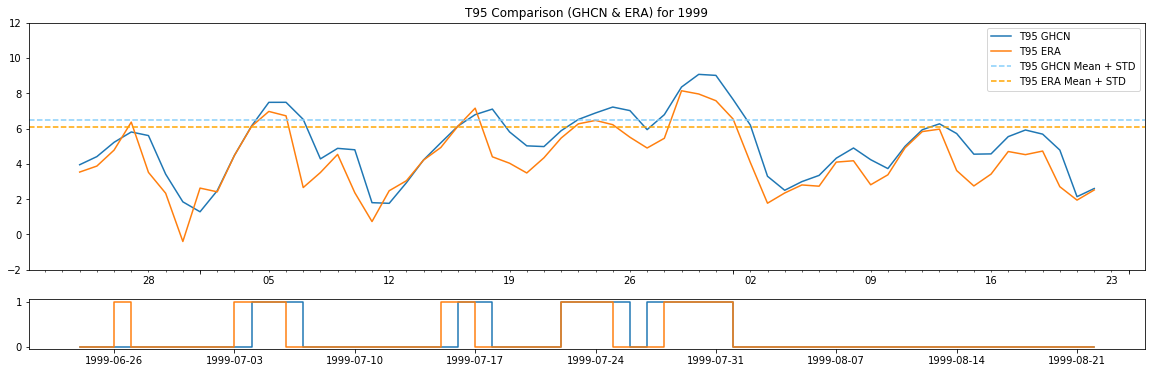

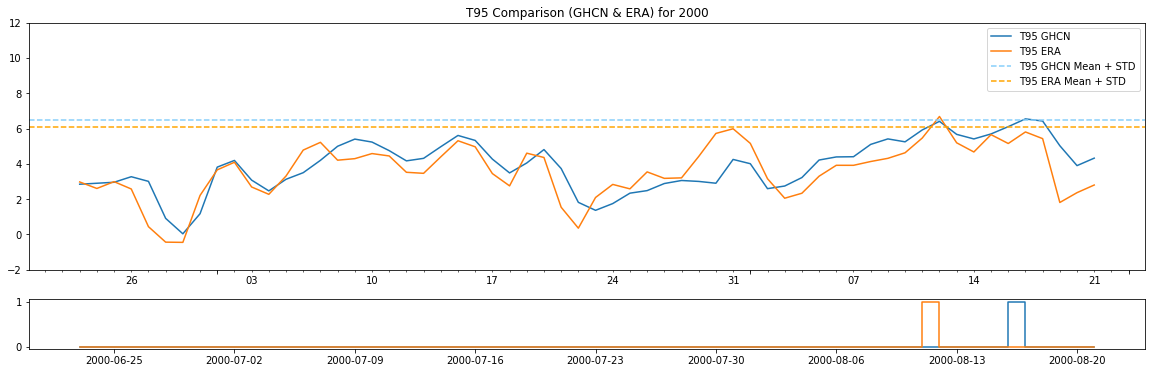

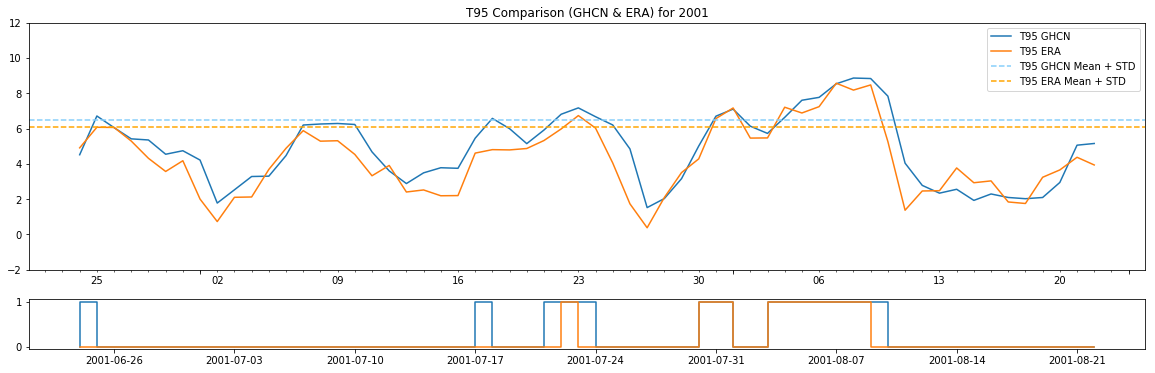

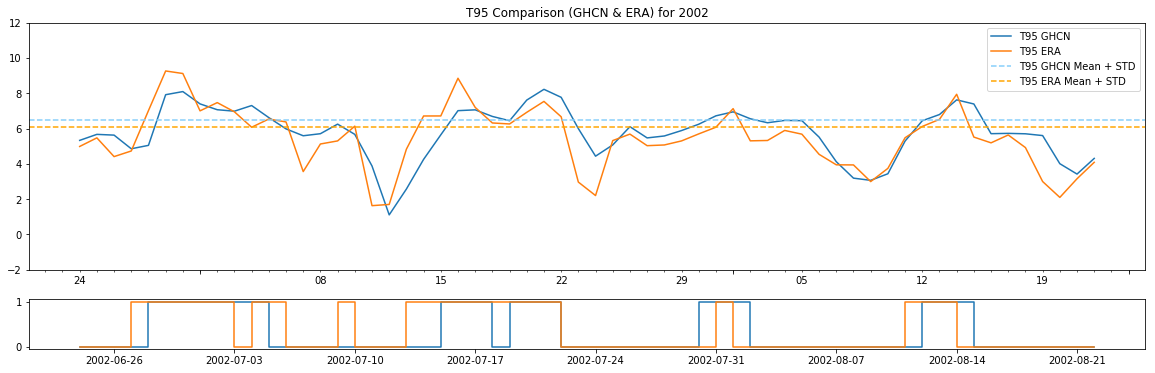

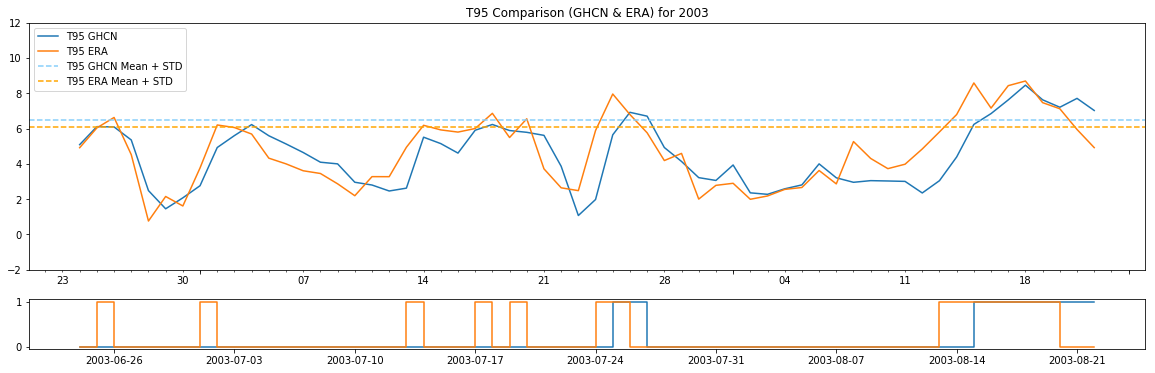

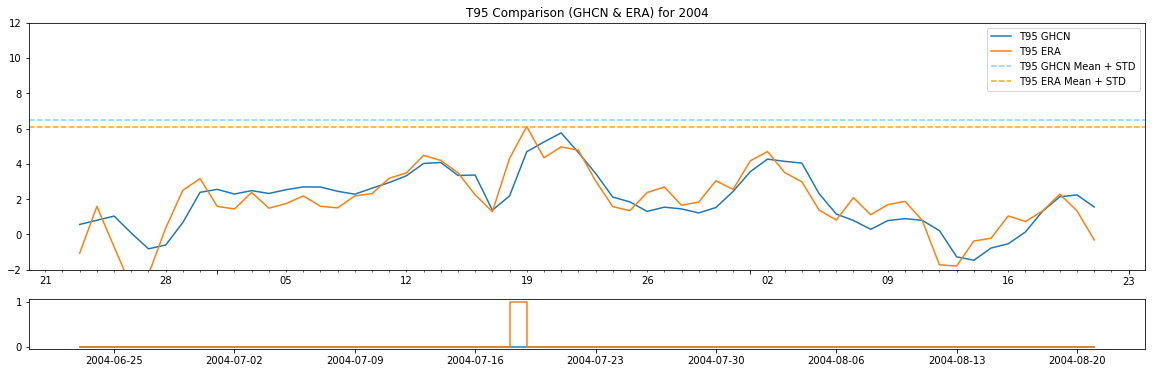

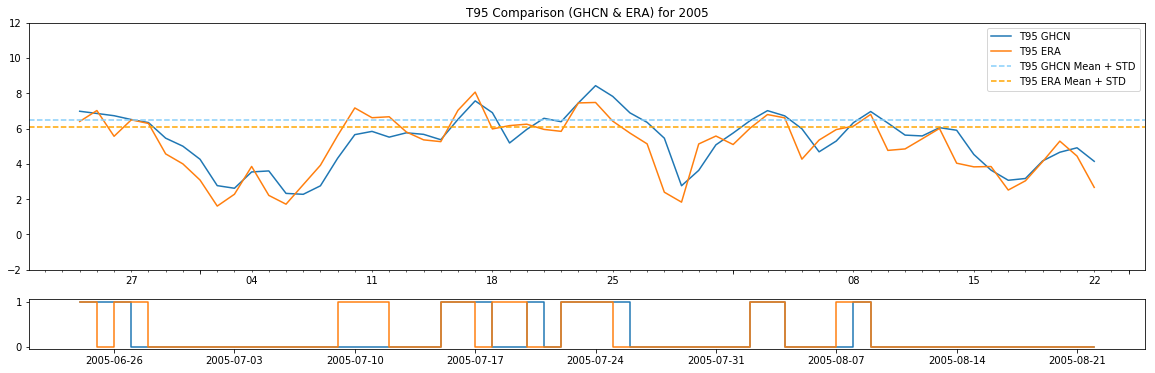

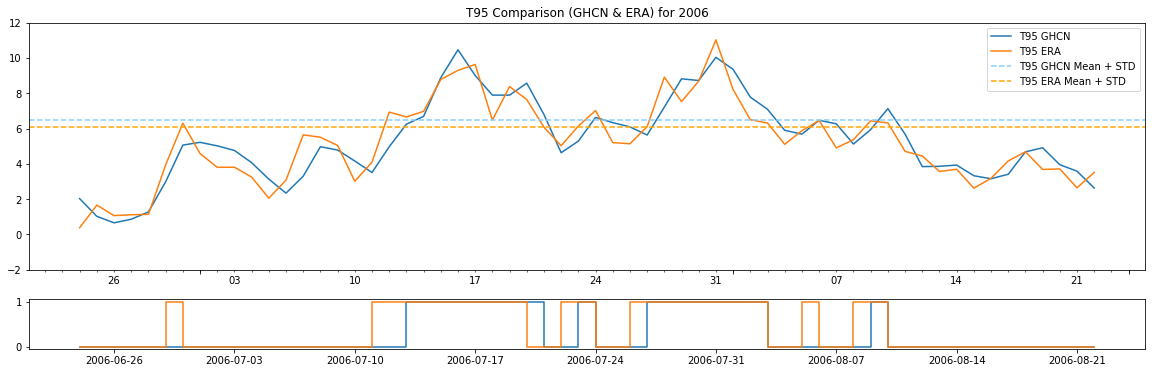

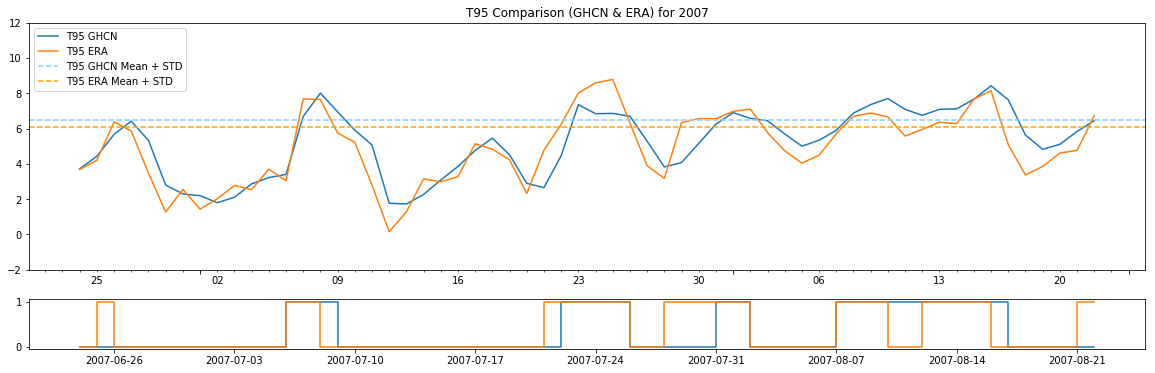

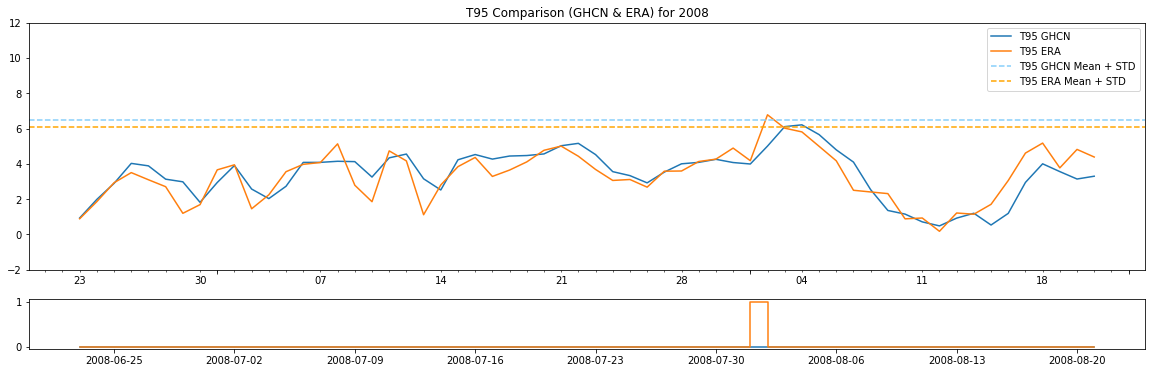

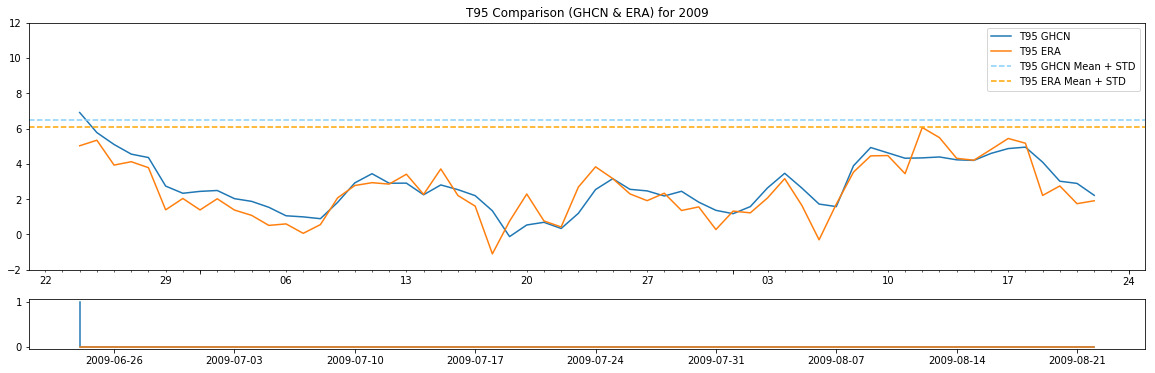

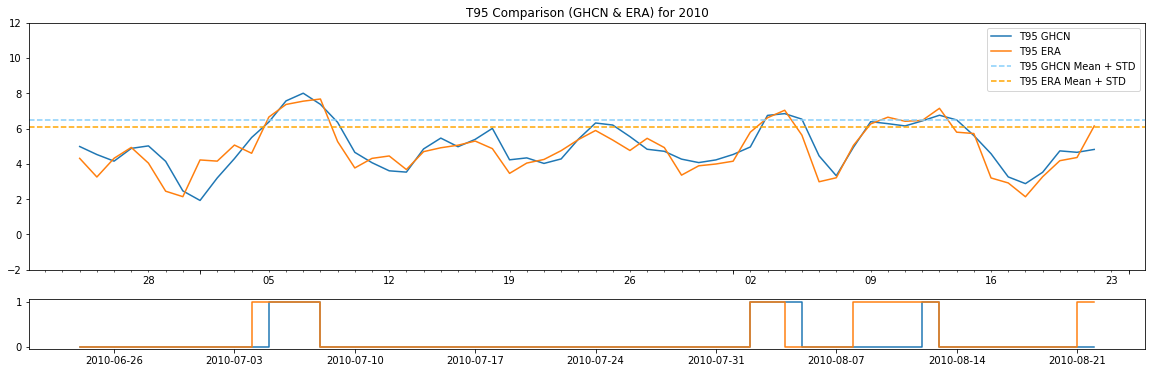

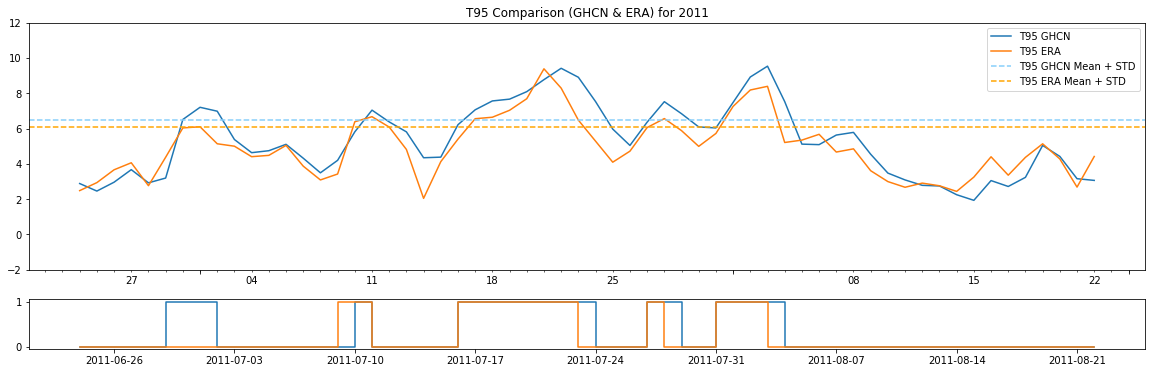

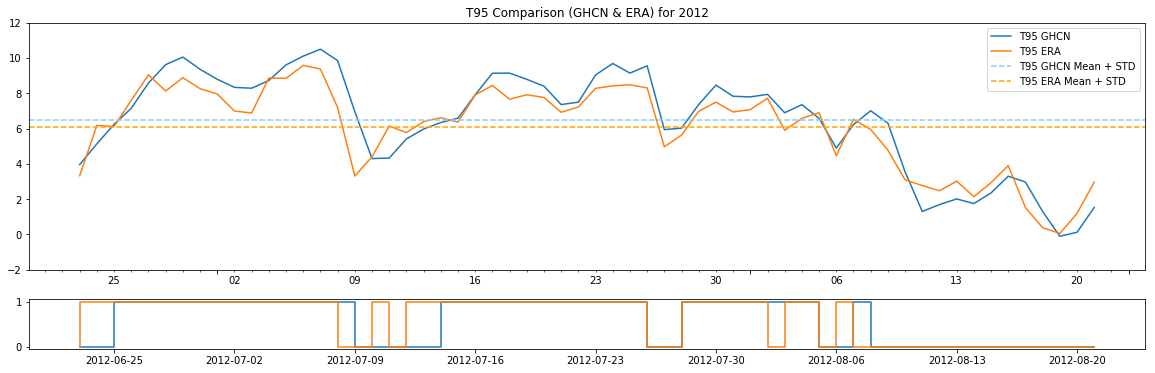

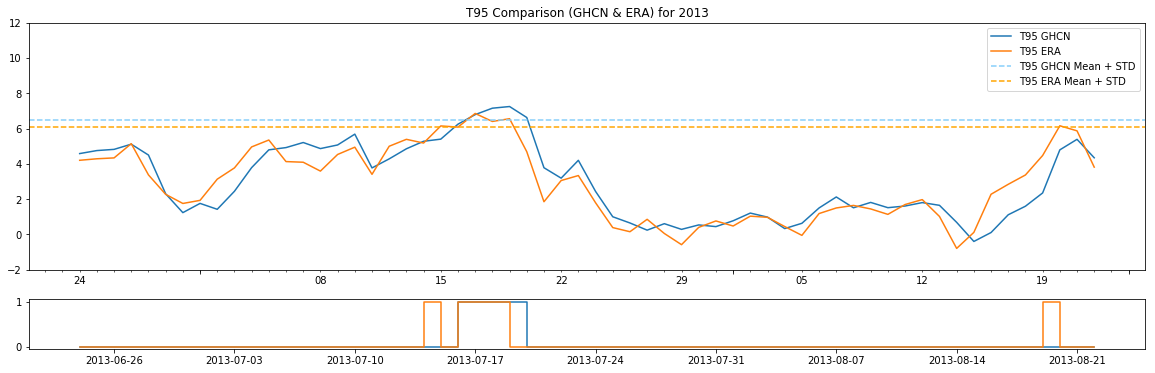

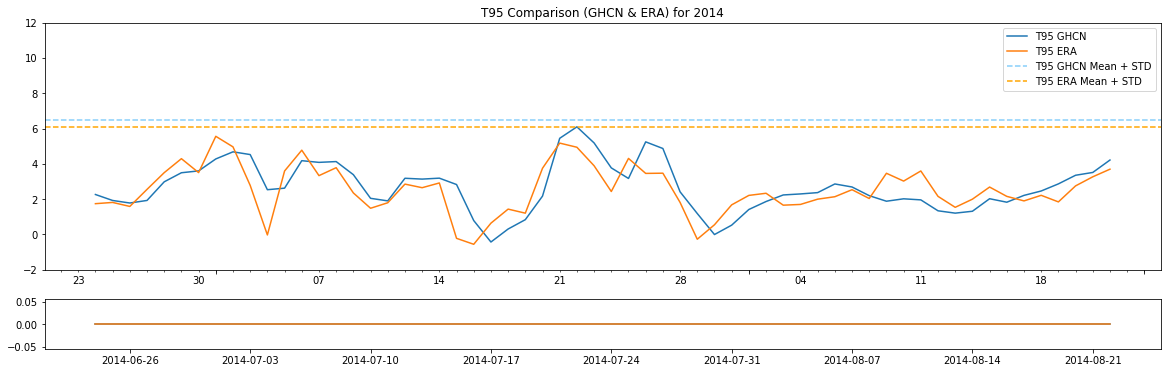

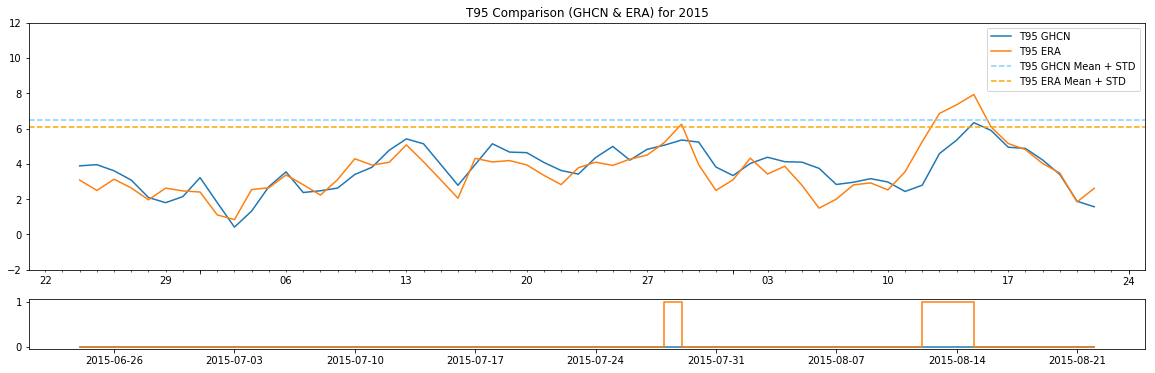

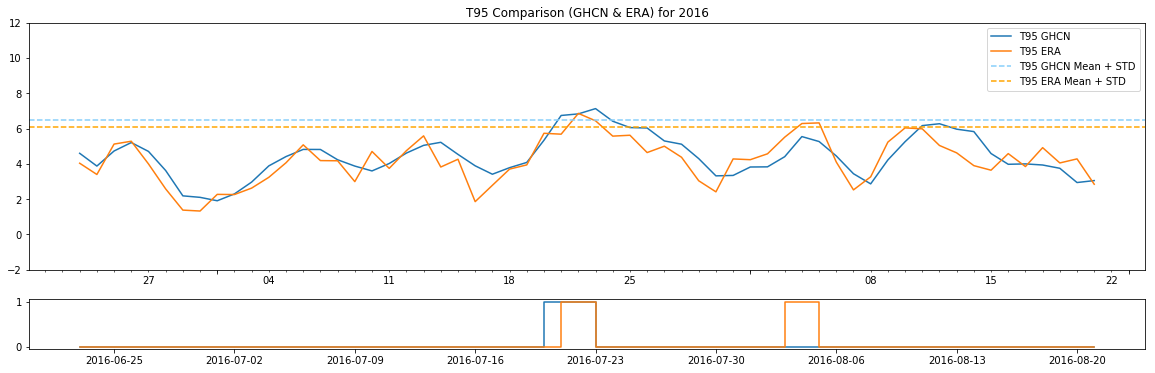

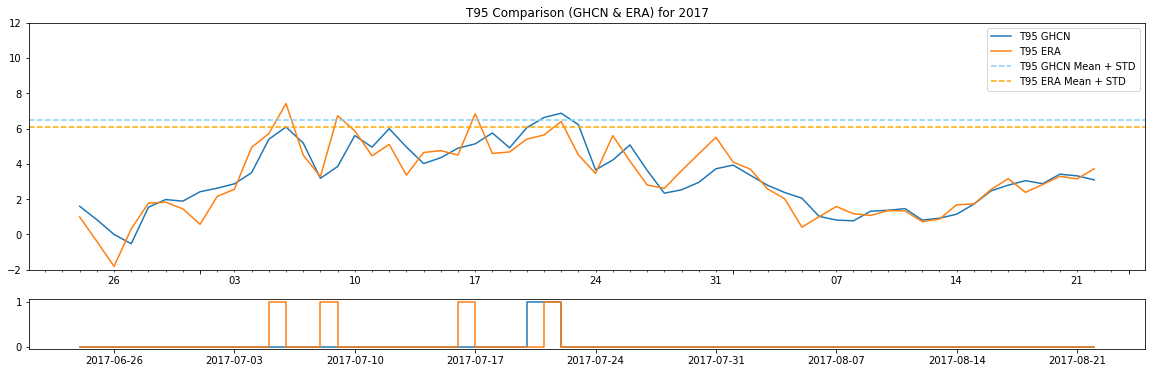

In [19]:
print("GHCN<->ERA Mean Squared Error:", np.mean((T95 - T95_era) ** 2))

T95_std = T95.mean() + T95.std()
T95_era_std = T95_era.mean() + T95_era.std()

# Create Big Figure
plt.rcParams['figure.figsize'] = [20, 6]

for (GHCN_year, GHCN_data), (ERA_year, ERA_data) in zip(T95.groupby(T95.index.year), T95_era.groupby(T95.index.year)):
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1])
    
    plt.subplot(gs[0])
    
    GHCN_data.plot(label="T95 GHCN", title=f"T95 Comparison (GHCN & ERA) for {GHCN_year}")
    ERA_data.plot(label="T95 ERA")
    plt.axhline(T95_std, c="lightskyblue", linestyle="--", label="T95 GHCN Mean + STD")
    plt.axhline(T95_era_std, c="orange", linestyle="--", label="T95 ERA Mean + STD")
    plt.ylim(-2, 12)
    plt.legend()
    
    plt.subplot(gs[1])
    plt.step(GHCN_data.index, GHCN_data > T95_std, label="GHCN Heat Wave Events")
    plt.step(ERA_data.index, ERA_data > T95_era_std, label="ERA Heat Wave Events")
    plt.show()

In [ ]:
# The Standardized Precipitation Index (SPI; McKee 1993) is the number of
# standard deviations that observed cumulative precipitation deviates from the climatological average.